# Cross-validation on Github data

In this notebook, we show how to use Deep4Cast to forecast a single time series of Github daily active users. The data can be gathered from [Github Archive](https://www.gharchive.org/) and is entirely public.

The idea of this notebook is to show how to use Deep4Cast to perform temporal cross-validation.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster, VectorScaler
from deep4cast.cv import FoldGenerator, MetricsEvaluator, CrossValidator
import deep4cast.models as models
import deep4cast.utils as utils

from skopt.space import Real, Integer, Categorical

%matplotlib inline

Using TensorFlow backend.


# Parameters

We first specify the parameters for the neural network forecasts, such as number of layers, etc. The architecture we will be using for forecasting is based on WaveNet.

In [2]:
horizon = 90 # forecasting horizon
lag = 360 # the lookback window is the same as the horizon
filters = 128 # number of convolutional filters per layer in the neural net
num_layers = 2 # the neural network number of layers
lr=0.0001
epochs=100
test_fraction = 0.1
n_folds=5

# Data preparation

The data set consists of only one time series, Github daily active users, that we want to model. In addition, we build a few dummy variables for holidays and such below.

In [3]:
# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('data/processed/github_dau_2011-2018.pkl')
data = df.drop(['month', 'day', 'age'], axis=1)
data = data.dropna()

# Log transform targets
data['count'] = np.log1p(data['count'])

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['count']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create lagged real features to include information about past seasonal behavior
lagged = data[real_values].shift(365-horizon)
lagged = lagged.rename(columns={column:column + '_lagged' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)

# Let's shift the holidays back by the horizon length for better forecasting on holidays
data['holiday'] = data['holiday'].shift(-horizon)

# Recalculate training & testing boundary
test_ind = data.index.where(data['date'] == dt.datetime(2017,6,4)).dropna().astype('int').values[0]

# Create a numpy array drop date columns
data_arr = data.drop(['date'], axis=1)
data_arr = np.expand_dims(data_arr.values, 0)

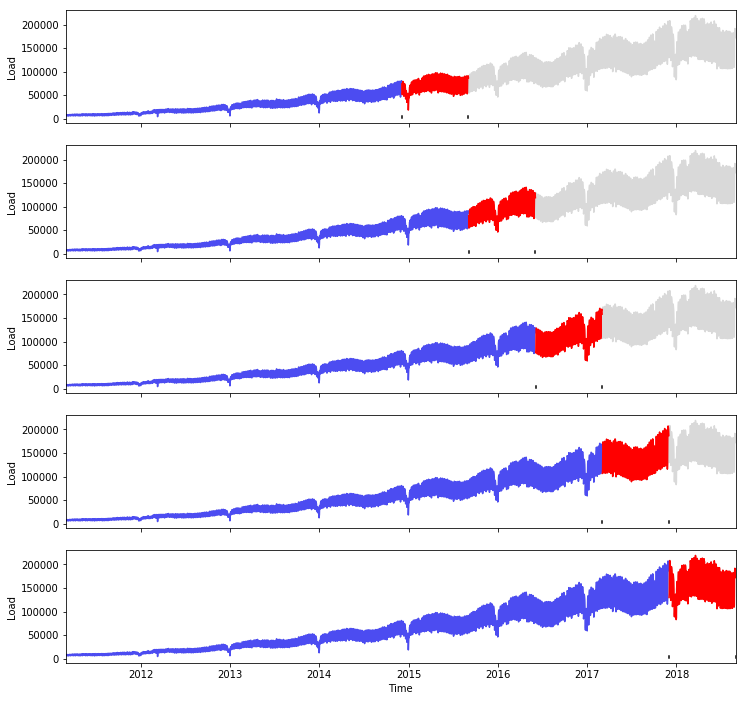

<Figure size 432x288 with 0 Axes>

In [8]:
# Let plot the target time series data folds that will be used for temporal cross-validation
test_length = int(len(df)*test_fraction)
train_length = len(df) - n_folds*test_length

fig, axes = plt.subplots(nrows=n_folds, ncols=1, sharex=True, figsize=(12, 12))
for ax, i in zip(axes.flat, range(n_folds)):
    x_train = df.date[:i*test_length+train_length]
    y_train = df['count'][:i*test_length+train_length]
    x_test = df.date[i*test_length+train_length:(i+1)*test_length+train_length]
    y_test = df['count'][i*test_length+train_length:(i+1)*test_length+train_length]
    x_all = df.date
    y_all = df['count']
    
    ax.plot(x_all, y_all, 'k-', alpha=0.15)
    ax.plot(x_train, y_train, 'b-', alpha=0.65)
    ax.plot(x_test, y_test, 'r-')
    ax.plot([min(x_test), min(x_test)], [2000, 5500], 'k-')
    ax.plot([max(x_test), max(x_test)], [2000, 5500], 'k-')
    ax.set_xlim([min(x_all), max(x_all)])
    ax.set_ylabel('Load')
plt.xlabel('Time')
plt.show()
plt.tight_layout()

# Model
The network architecture used in this example is based on WaveNet. We also need to build objects that handle data preparation and evaluation.

In [5]:
# Forecaster and model setup
model = models.WaveNet(filters=filters, num_layers=num_layers)
forecaster = Forecaster(model, lr=lr, epochs=epochs)

# Fold generator
fold_generator = FoldGenerator(
    data=data_arr, 
    targets=[0], 
    lag=lag, 
    horizon=horizon, 
    test_fraction=test_fraction, 
    n_folds=n_folds
)

# Evaluator for evaluating a few metrics
evaluator = MetricsEvaluator(metrics = ['smape', 'pinball_loss', 'coverage'])

# A data scaler is needed to bring normalize the data before fitting the model
scaler = VectorScaler(targets = [0, -1])

# Cross-validator brings all components together
validator = CrossValidator(forecaster, fold_generator, evaluator, scaler)

# Cross Validation

Perform cross-validation on the dataset. Here, we have an expanding training data window and a fixed-size testing data window.

In [6]:
# Evaluate on the cross-validation folds
metrics = validator.evaluate(verbose=True)

Results for smape is 0.43.
Results for pinball_loss is 0.02.
Results for coverage is ([1.11, 3.89, 17.78, 40.0, 76.11, 97.22, 100.0], [1, 5, 25, 50, 75, 95, 99]).
Evaluation took 102.90941715240479 seconds.
Results for smape is 0.21.
Results for pinball_loss is 0.01.
Results for coverage is ([0.0, 1.67, 15.56, 55.56, 92.22, 100.0, 100.0], [1, 5, 25, 50, 75, 95, 99]).
Evaluation took 97.55084466934204 seconds.
Results for smape is 0.47.
Results for pinball_loss is 0.02.
Results for coverage is ([0.0, 1.67, 17.22, 36.11, 67.78, 92.22, 98.89], [1, 5, 25, 50, 75, 95, 99]).
Evaluation took 94.36568260192871 seconds.
Results for smape is 1.03.
Results for pinball_loss is 0.05.
Results for coverage is ([12.78, 18.89, 31.11, 43.33, 58.33, 72.78, 78.33], [1, 5, 25, 50, 75, 95, 99]).
Evaluation took 94.11096143722534 seconds.
Results for smape is 0.17.
Results for pinball_loss is 0.01.
Results for coverage is ([1.11, 3.33, 18.89, 60.56, 82.78, 98.89, 100.0], [1, 5, 25, 50, 75, 95, 99]).
Evaluati

# Evaluation

   smape  pinball_loss                                           coverage
0   0.43          0.02  ([1.11, 3.89, 17.78, 40.0, 76.11, 97.22, 100.0...
1   0.21          0.01  ([0.0, 1.67, 15.56, 55.56, 92.22, 100.0, 100.0...
2   0.47          0.02  ([0.0, 1.67, 17.22, 36.11, 67.78, 92.22, 98.89...
3   1.03          0.05  ([12.78, 18.89, 31.11, 43.33, 58.33, 72.78, 78...
4   0.17          0.01  ([1.11, 3.33, 18.89, 60.56, 82.78, 98.89, 100....
smape           0.462
pinball_loss    0.022
dtype: float64


Text(0,0.5,'Prediction quantile')

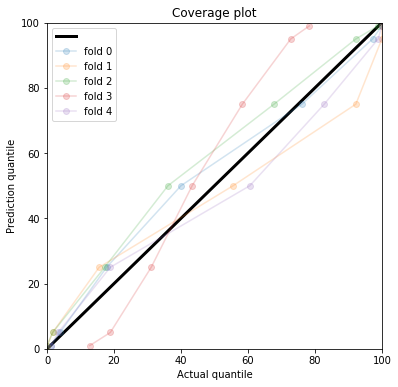

In [7]:
# Let's look at the cross-validation results
print(metrics)
print(metrics.mean())

# Plot probability calibration plots
x = [1, 5, 25, 50, 75, 95, 99]
coverages = metrics.iloc[:-2,-7:]
plt.figure(figsize=(6, 6))
plt.plot([0] + x + [100], [0] + x + [100], 'k-', linewidth=3)
for cov_x, cov_y in metrics.coverage:
    plt.plot(cov_x, cov_y, 'o-', alpha=0.2)
plt.legend([''] + ['fold ' + str(s) for s in np.arange(n_folds)])
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')
plt.xlabel('Actual quantile')
plt.ylabel('Prediction quantile')